In [1]:
#
# Extract spectra of source a and b in the i16293 ALMA data

import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as aiof
from spectral_cube import SpectralCube
import pyregion
import astropy.units as u
from astropy.coordinates import SkyCoord
import aplpy
import os

%matplotlib inline 
matplotlib.rcParams['axes.linewidth'] = 2.5
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: license expired

    the package mklfft 2.0 was published on 2015-11-13,
    however the mkl license expiration date is 2015-04-12.
    You may be able to run earlier versions of mklfft using your
    current license.  A new license can be purchased at: http://continuum.io
    To revert to an earlier set of conda packages, use:
    $ conda list --revisions
    ...
    $ conda install --revision <REVISION NUMBER>

    


In [12]:
def get_ss_reg(src):
    sa = str(int(src.ra.hms[0]))+':'+str(int(src.ra.hms[1]))+':'+str(src.ra.hms[2])
    if src.dec.deg <0:
        sd='-'+str(int(abs(src.dec.dms[0])))+':'+str(int(abs(src.dec.dms[1])))+':'+str(abs(src.dec.dms[2]))
    else:
        sd=str(int(abs(src.dec.dms[0])))+':'+str(int(abs(src.dec.dms[1])))+':'+str(abs(src.dec.dms[2]))
    #
    return sa+', '+sd
    
# regions
source = SkyCoord('19:01:33.87 -36:57:45.3', unit=(u.hourangle, u.deg))
rad = 0.5*u.arcsec

# define the source region
reg = pyregion.parse("FK5; circle("+get_ss_reg(source)+","+str(rad.to(u.degree).value)+")")

# define the sky annulus
rad_in = 1.0*u.arcsec
rad_out = 2.0*u.arcsec
sky_reg = pyregion.parse("FK5; annulus("+get_ss_reg(source)+","+str(rad_in.to(u.degree).value)+","+str(rad_out.to(u.degree).value)+")")


In [19]:
mycube = 'CrA16.12CO.fits'
nu0 = 230538.00*u.MHz
cube = SpectralCube.read(mycube)
sc = cube.subcube_from_ds9region(reg)
sc_vel = sc.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=nu0)
sc_sky = cube.subcube_from_ds9region(sky_reg)
sc_sky_vel = sc_sky.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=nu0)

y = sc_vel.mean(axis=(1,2)).value
y_sky = sc_sky_vel.mean(axis=(1,2)).value

ydif = y-y_sky
yrms = np.std(ydif)
ymean = ydif.mean()

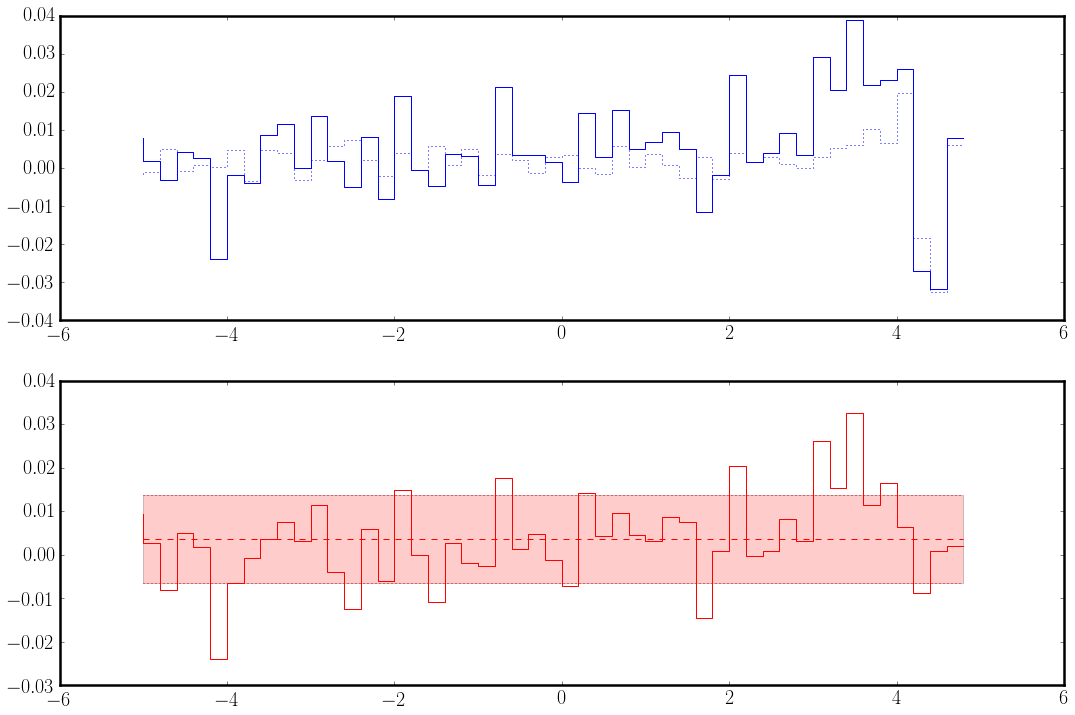

In [27]:
#fig = plt.figure(figsize=(18,6))
fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, squeeze=True, figsize=(18,6*2))
ax[0].step(sc_vel.spectral_axis,y,color='b')
ax[0].step(sc_vel.spectral_axis,y_sky,linestyle='dotted',color='b')
ax[1].step(sc_vel.spectral_axis,y-y_sky,color='r')
ax[1].fill_between([sc_vel.spectral_axis.value[0],sc_vel.spectral_axis.value[-1]],[ymean+yrms,ymean+yrms], [ymean-yrms,ymean-yrms],  facecolor='red', alpha=0.2)
ax[1].plot([sc_vel.spectral_axis.value[0],sc_vel.spectral_axis.value[-1]],[ymean,ymean],linestyle='dashed',color='r')
ax[1].plot([sc_vel.spectral_axis.value[0],sc_vel.spectral_axis.value[-1]],[ymean+yrms,ymean+yrms],linestyle='dotted',color='r')
ax[1].plot([sc_vel.spectral_axis.value[0],sc_vel.spectral_axis.value[-1]],[ymean-yrms,ymean-yrms],linestyle='dotted',color='r')